In [ ]:
%load_ext autoreload
%autoreload 2

import jax
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from lalinference import BurstSineGaussian
from ripplegw.waveforms import SineGaussian

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

params = {
    "text.usetex" : True,
    "font.family": "serif",
    "ytick.color" : "black",
    "xtick.color" : "black",
    "axes.labelcolor" : "black",
    "axes.edgecolor" : "black",
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 16,
    "figure.titlesize": 16
}

plt.rcParams.update(params)

In [2]:
def get_max_difference(diff_hcross, diff_hplus):
    """Helper function to calculate the maximum difference between the LAL and ripple waveforms."""
    length = len(diff_hcross)
    max_diff_hcross = jnp.array([jnp.max(jnp.abs(diff_hcross[i])) for i in range(length)])
    max_diff_hplus = jnp.array([jnp.max(jnp.abs(diff_hplus[i])) for i in range(length)])
    return max_diff_hcross, max_diff_hplus

def get_mean_difference(diff_hcross, diff_hplus):
    """Helper function to calculate the mean difference between the LAL and ripple waveforms."""
    length = len(diff_hcross)
    mean_diff_hcross = jnp.array([jnp.mean(jnp.abs(diff_hcross[i])) for i in range(length)])
    mean_diff_hplus = jnp.array([jnp.mean(jnp.abs(diff_hplus[i])) for i in range(length)])
    return mean_diff_hcross, mean_diff_hplus

def get_mean_squared_difference(diff_hcross, diff_hplus):
    """Helper function to calculate the mean squared difference between the LAL and ripple waveforms."""
    length = len(diff_hcross)
    mean_squared_diff_hcross = jnp.array([jnp.mean(diff_hcross[i] ** 2) for i in range(length)])
    mean_squared_diff_hplus = jnp.array([jnp.mean(diff_hplus[i] ** 2) for i in range(length)])
    return mean_squared_diff_hcross, mean_squared_diff_hplus

def vary_parameters(
    quality, frequency, hrss, phase, eccentricity, duration = 10.0, fs=4096, delta_t=1 / 4096
):
    """Helper function to generate sine-gaussian waveforms with varying parameters."""
    hplus, hcross = SineGaussian.gen_SineGaussian_hphc(quality, frequency, hrss, phase, eccentricity, duration, fs)
    hcross_lal, hplus_lal, hcross_ripple, hplus_ripple, diff_hcross, diff_hplus = [], [], [], [], [], []
    length = max(len(quality), len(frequency), len(hrss), len(phase), len(eccentricity))
    
    for i in range(length):
        hplus_, hcross_ = BurstSineGaussian(
            Q=quality[i].item(),
            centre_frequency=frequency[i].item(),
            hrss=hrss[i].item(),
            eccentricity=eccentricity[i].item(),
            phase=phase[i].item(),
            delta_t=delta_t,
        )
        hplus_ = hplus_.data.data
        hcross_ = hcross_.data.data
        n_samples = len(hplus_)
        start, stop = (
            len(hcross[i]) // 2 - n_samples // 2,
            len(hcross[i]) // 2 + n_samples // 2 + 1,
        )
        hcross_ripple.append(hcross[i][start:stop])
        hplus_ripple.append(hplus[i][start:stop])
        hcross_lal.append(hcross_)
        hplus_lal.append(hplus_)
        diff_hcross.append(hcross_ripple[i] - hcross_lal[i])
        diff_hplus.append(hplus_ripple[i] - hplus_lal[i])
    return hcross_lal, hplus_lal, hcross_ripple, hplus_ripple, diff_hcross, diff_hplus

# **64-bit Precision**

In [3]:
#enable 64-bit precision
jax.config.update("jax_enable_x64", True)
print(jnp.ones(1).dtype)

float64


### Generate waveforms by varying all parameters at once

In [4]:
quality = jnp.linspace(3, 100, 100)
frequency = jnp.logspace(1, 3, 100)
hrss = jnp.logspace(-23, -6, 100)
phase = jnp.linspace(0, 2 * np.pi, 100)
eccentricity = jnp.linspace(0, 0.99, 100)

hcross_lal, hplus_lal, hcross_ripple, hplus_ripple, \
diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)
max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)
print(f"Datatype: {max_diff_hcross.dtype}")

Datatype: float64


### Plot a comparision

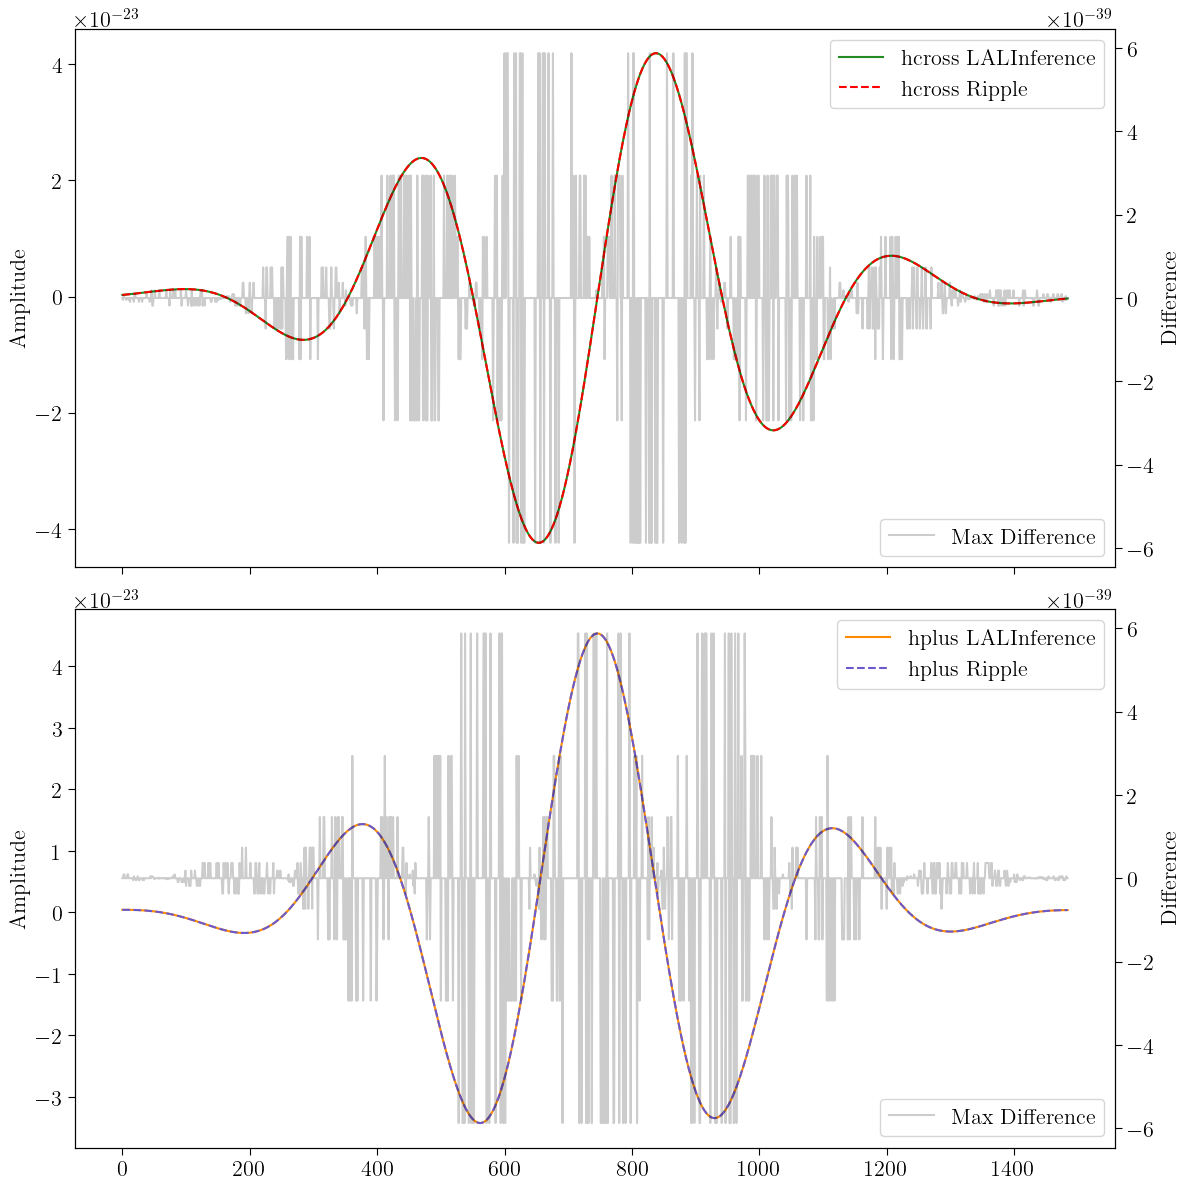

Max difference in hcross: 5.877471754111438e-39
Max difference in hplus: 5.877471754111438e-39
Paraqmeters:
    quality=3.980, frequency=10.476, hrss=1.4849682622544576e-23, phase=0.063, eccentricity=0.010


In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# choose a random waveform
i = np.random.randint(0, 10)

# subplot for hcross
ax1_ = ax1.twinx()
ax1_.plot(diff_hcross[i], label="Max Difference", color="black", alpha=0.2)
ax1.plot(hcross_lal[i], label="hcross LALInference", linestyle="-", color="forestgreen")
ax1.plot(hcross_ripple[i], label="hcross Ripple", linestyle="--", color="red")
ax1.set_ylabel("Amplitude")
ax1_.set_ylabel("Difference")
max_diff = np.max(np.abs(max_diff_hcross[i]))
ax1_.set_ylim(-1.1*max_diff, 1.1*max_diff)
ax1.legend(loc="upper right")
ax1_.legend(loc="lower right")

# subplot for hplus
ax2_ = ax2.twinx()
ax2_.plot(diff_hplus[i], label="Max Difference", color="black", alpha=0.2)
ax2.plot(hplus_lal[i], label="hplus LALInference", linestyle="-", color="darkorange")
ax2.plot(hplus_ripple[i], label="hplus Ripple", linestyle="--", color="slateblue")
ax2.set_ylabel("Amplitude")
ax2_.set_ylabel("Difference")
max_diff = np.max(np.abs(max_diff_hplus[i]))
ax2_.set_ylim(-1.1*max_diff, 1.1*max_diff)
ax2.legend(loc="upper right")
ax2_.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Max difference in hcross: {max_diff_hcross[i]}\nMax difference in hplus: {max_diff_hplus[i]}\nParaqmeters:\n\
    quality={quality[i].item():.3f}, frequency={frequency[i].item():.3f}, hrss={hrss[i].item()}, phase={phase[i].item():.3f}, eccentricity={eccentricity[i].item():.3f}")

### Vary each parameter independently by fixing others

The constant values of other parameters were chosen to be somewhere in the middle of the range, except for the hrss value which was chosen just slightly lower than value that crosses the noise floor

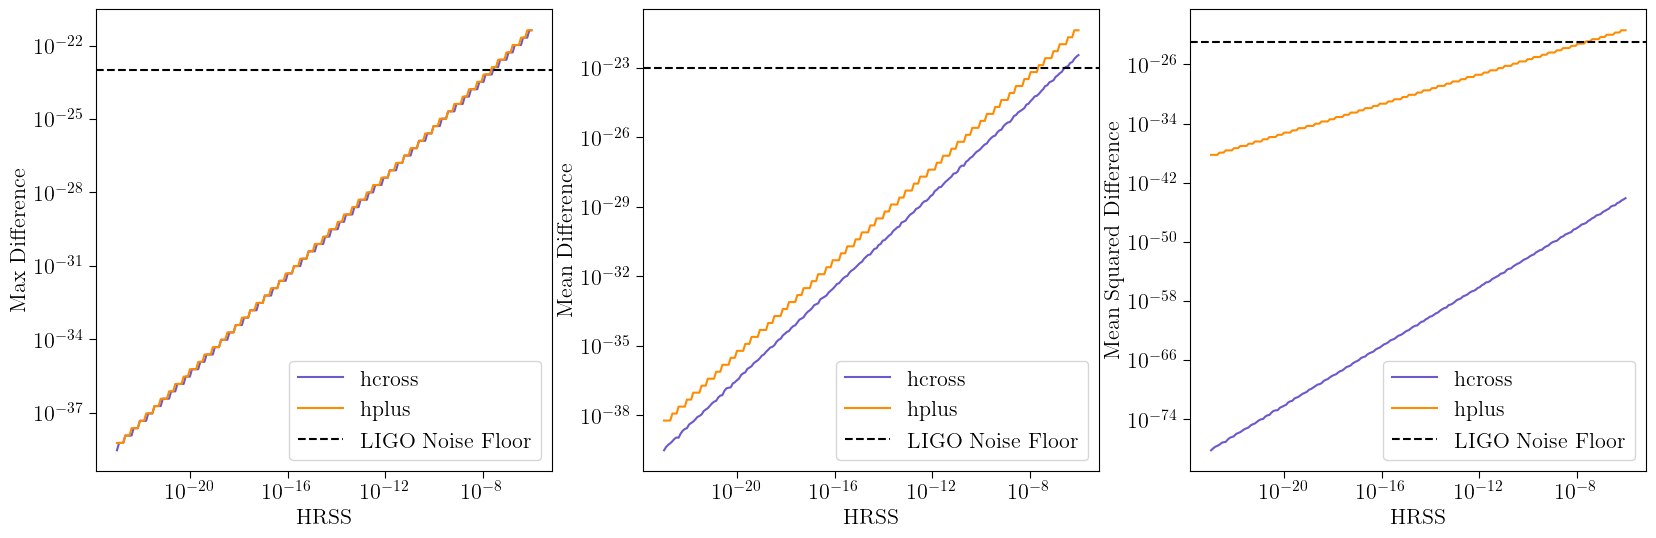

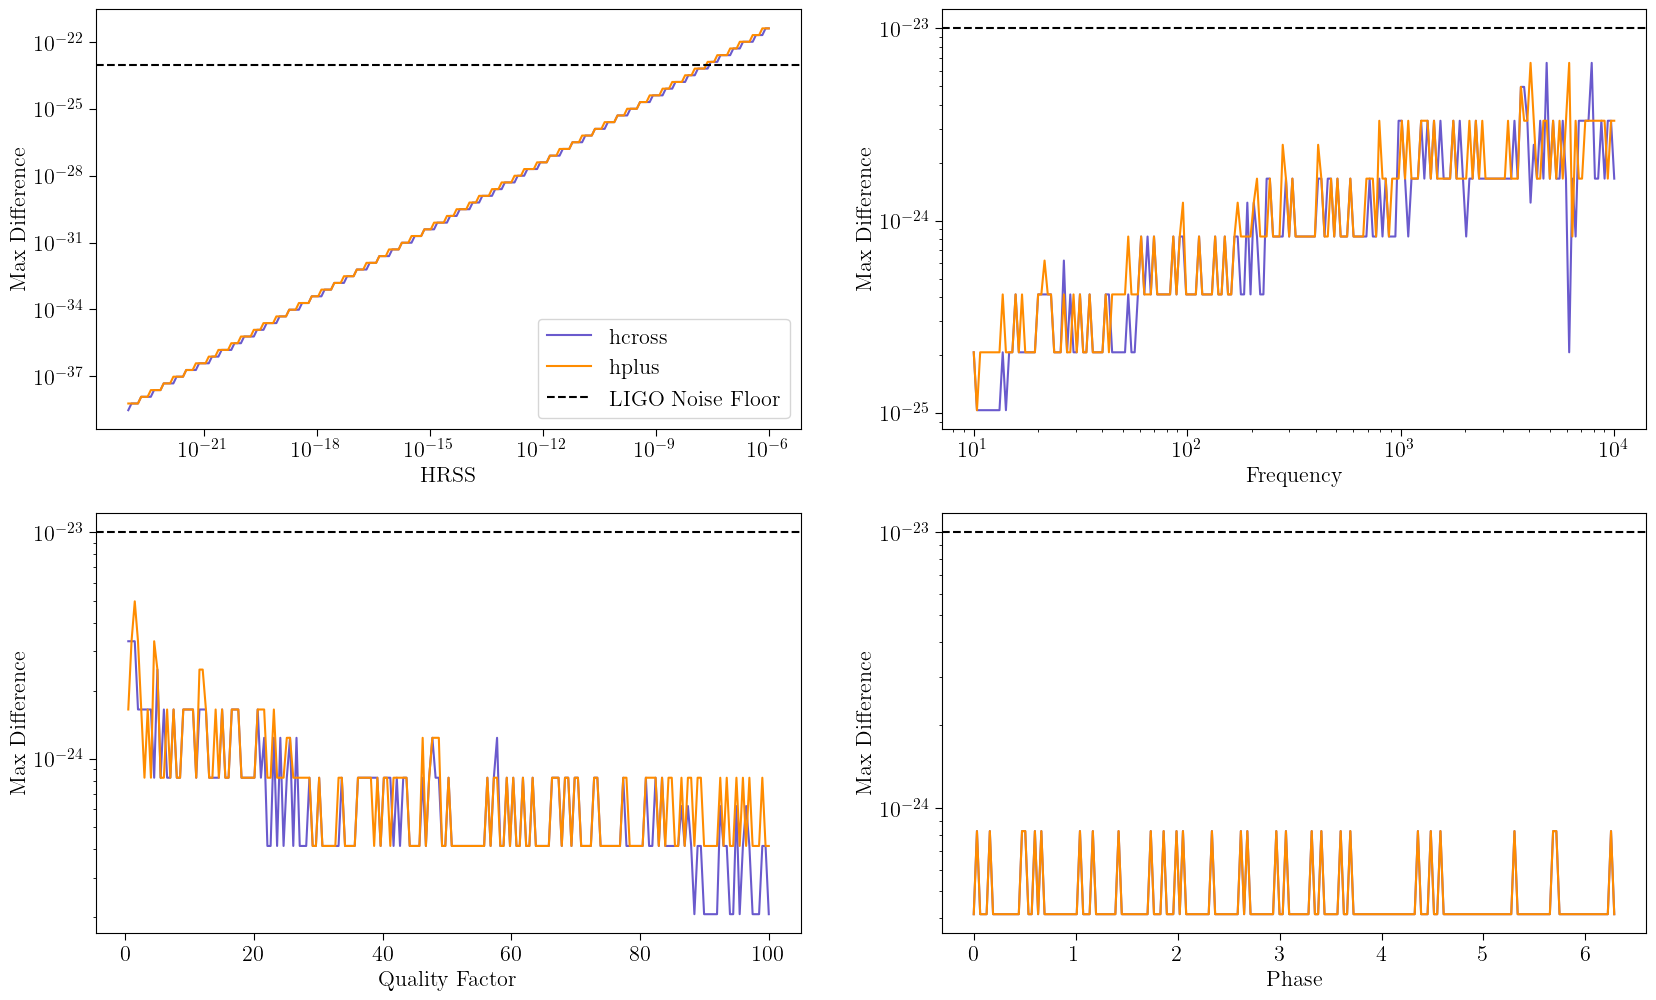

In [6]:
N = 200
LIGO_NOISE_FLOOR = 1e-23 # https://www.ligo.org/science/Publication-O1Noise/Images/IFO_STRAIN.png


quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), 100*jnp.ones(N), \
    jnp.logspace(-23, -6, N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)

max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)
mean_diff_hcross, mean_diff_hplus = get_mean_difference(diff_hcross, diff_hplus)
mean_squared_diff_hcross, mean_squared_diff_hplus = get_mean_squared_difference(diff_hcross, diff_hplus)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, (diff, label) in enumerate(zip([max_diff_hcross, mean_diff_hcross, mean_squared_diff_hcross], ["Max", "Mean", "Mean Squared"])):
    ax[i].plot(hrss, diff, label="hcross", color="slateblue")
    ax[i].plot(hrss, max_diff_hplus, label="hplus", color="darkorange")
    ax[i].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlabel("HRSS")
    ax[i].set_ylabel(f"{label} Difference")
    ax[i].legend()
plt.show()


fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax[0, 0].plot(hrss, max_diff_hcross, label="hcross", color="slateblue")
ax[0, 0].plot(hrss, max_diff_hplus, label="hplus", color="darkorange")
ax[0, 0].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
ax[0, 0].set_xlabel("HRSS")
ax[0, 0].set_ylabel("Max Difference")
ax[0, 0].legend()

quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), jnp.logspace(1, 4, N), \
    1e-9*jnp.ones(N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)
max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)

ax[0, 1].plot(frequency, max_diff_hcross, label="hcross", color="slateblue")
ax[0, 1].plot(frequency, max_diff_hplus, label="hplus", color="darkorange")
ax[0, 1].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[0, 1].set_xscale("log")
ax[0, 1].set_yscale("log")
ax[0, 1].set_xlabel("Frequency")
ax[0, 1].set_ylabel("Max Difference")

quality, frequency, hrss, phase, eccentricity = jnp.linspace(0, 100, N), 100*jnp.ones(N), \
    1e-9*jnp.ones(N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)
max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)


ax[1, 0].plot(quality, max_diff_hcross, label="hcross", color="slateblue")
ax[1, 0].plot(quality, max_diff_hplus, label="hplus", color="darkorange")
ax[1, 0].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[1, 0].set_yscale("log")
ax[1, 0].set_xlabel("Quality Factor")
ax[1, 0].set_ylabel("Max Difference")


quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), 100*jnp.ones(N), \
    1e-9*jnp.ones(N), jnp.linspace(0, 2*jnp.pi, N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)
max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)

ax[1, 1].plot(phase, max_diff_hcross, label="hcross", color="slateblue")
ax[1, 1].plot(phase, max_diff_hplus, label="hplus", color="darkorange")
ax[1, 1].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[1, 1].set_yscale("log")
ax[1, 1].set_xlabel("Phase")
ax[1, 1].set_ylabel("Max Difference")

plt.show()

### Pairwise comparsions

In [7]:
quality = jnp.array(np.linspace(3, 100, 10))
frequency = jnp.array(np.logspace(1, 3, 100))
hrss = jnp.array(np.logspace(-15, -6, 100))
phase = jnp.pi*jnp.ones(100000)
eccentricity = 0.5*jnp.ones(100000)

# generate paramter space
quality, frequency, hrss = jnp.meshgrid(quality, frequency, hrss)
quality, frequency, hrss = quality.flatten(), frequency.flatten(), hrss.flatten()

max_diff_hcross, max_diff_hplus = [], []
mean_diff_hcross, mean_diff_hplus = [], []
mean_squared_diff_hcross, mean_squared_diff_hplus = [], []

for i in range(100):
    *_, diff_hcross_, diff_hplus_ = vary_parameters(
        quality[i*1000: (i+1)*1000], frequency[i*1000: (i+1)*1000], hrss[i*1000: (i+1)*1000], phase[i*1000: (i+1)*1000], eccentricity[i*1000: (i+1)*1000]
    )
    max_diff_hcross_, max_diff_hplus_ = get_max_difference(diff_hcross_, diff_hplus_)
    mean_diff_hcross_, mean_diff_hplus_ = get_mean_difference(diff_hcross_, diff_hplus_)
    mean_squared_diff_hcross_, mean_squared_diff_hplus_ = get_mean_squared_difference(diff_hcross_, diff_hplus_)
    for j in range(1000):
        max_diff_hcross.append(max_diff_hcross_[j])
        max_diff_hplus.append(max_diff_hplus_[j])
        mean_diff_hcross.append(mean_diff_hcross_[j])
        mean_diff_hplus.append(mean_diff_hplus_[j])
        mean_squared_diff_hcross.append(mean_squared_diff_hcross_[j])
        mean_squared_diff_hplus.append(mean_squared_diff_hplus_[j])

max_diff_hcross, max_diff_hplus = np.array(max_diff_hcross), np.array(max_diff_hplus)
mean_diff_hcross, mean_diff_hplus = np.array(mean_diff_hcross), np.array(mean_diff_hplus)
mean_squared_diff_hcross, mean_squared_diff_hplus = np.array(mean_squared_diff_hcross), np.array(mean_squared_diff_hplus)

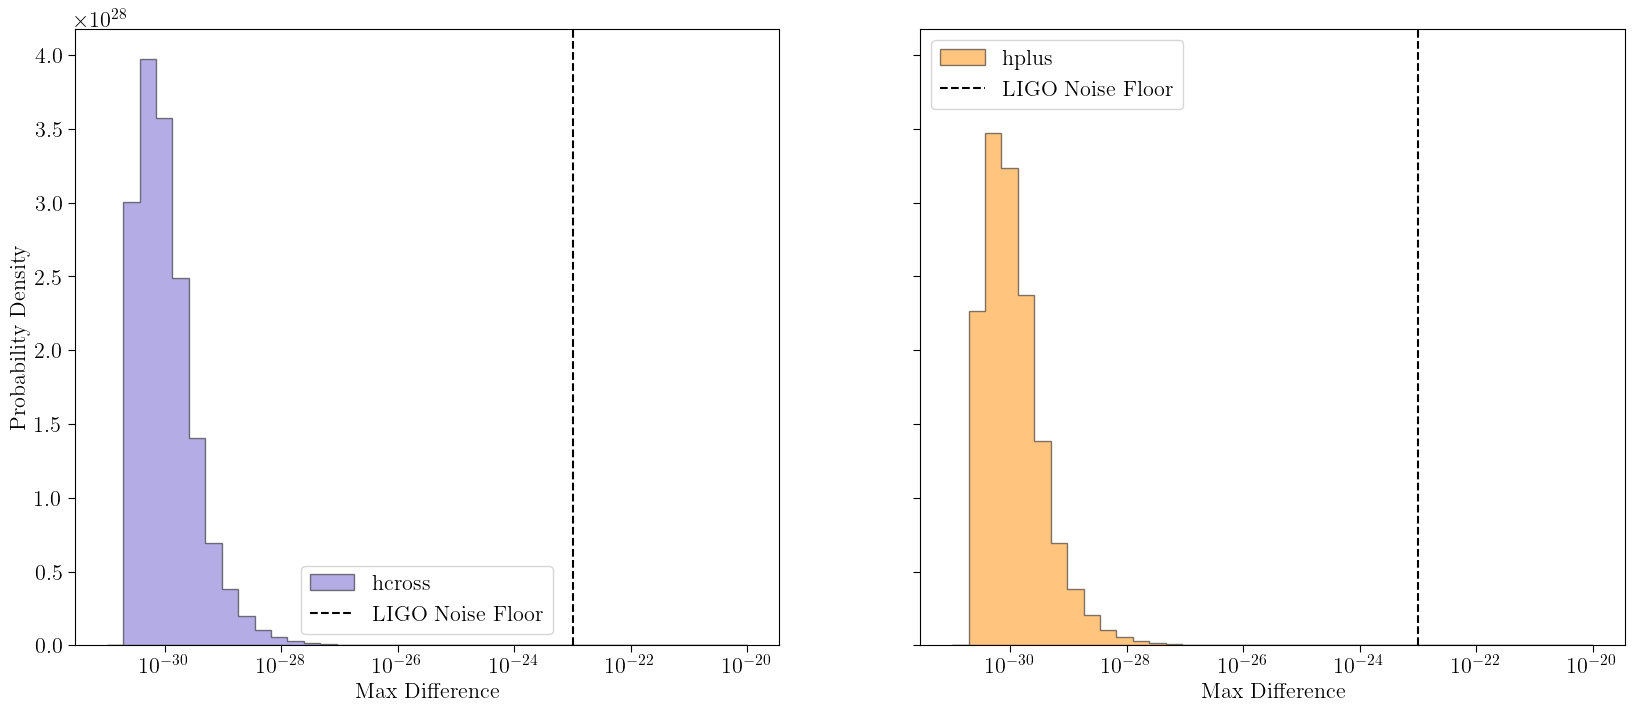

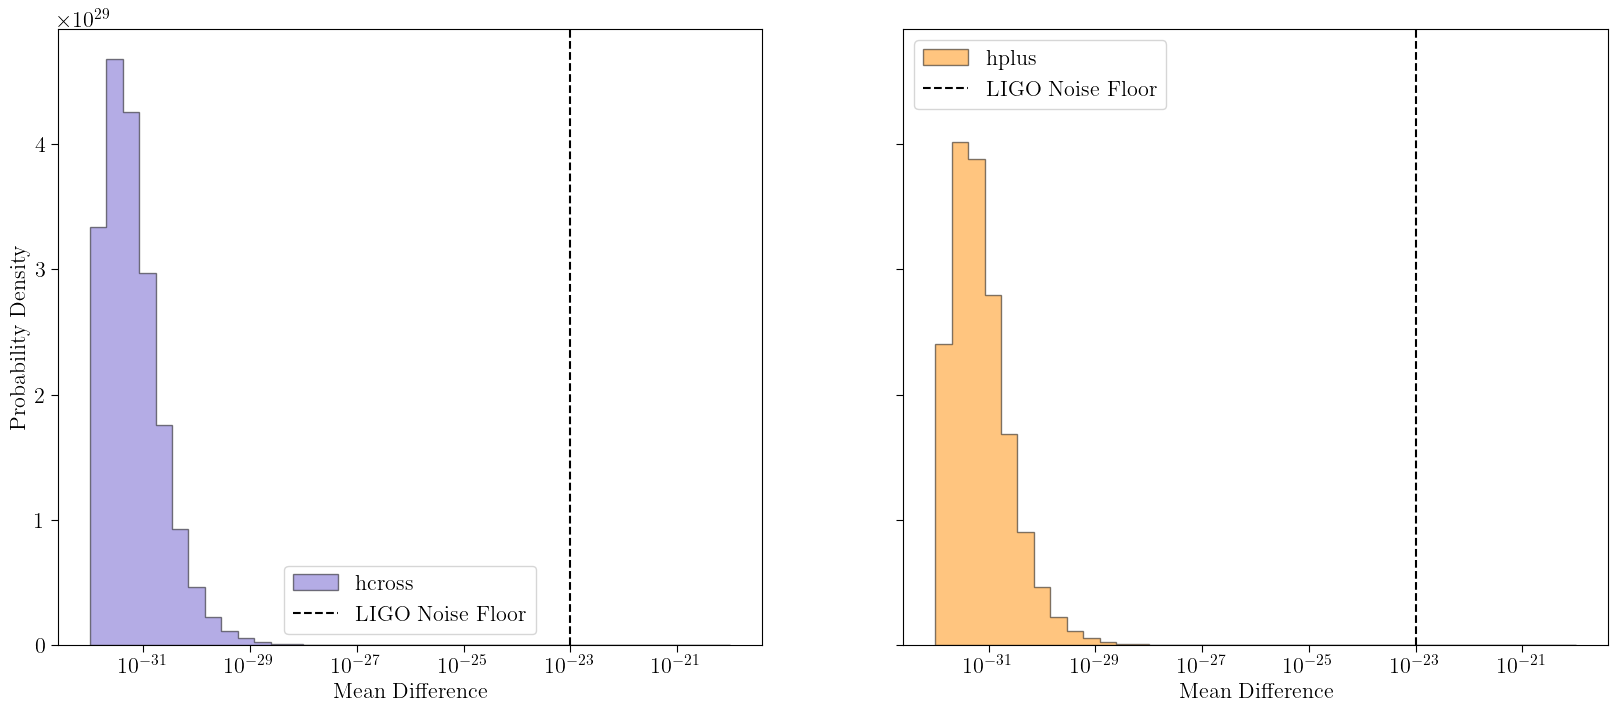

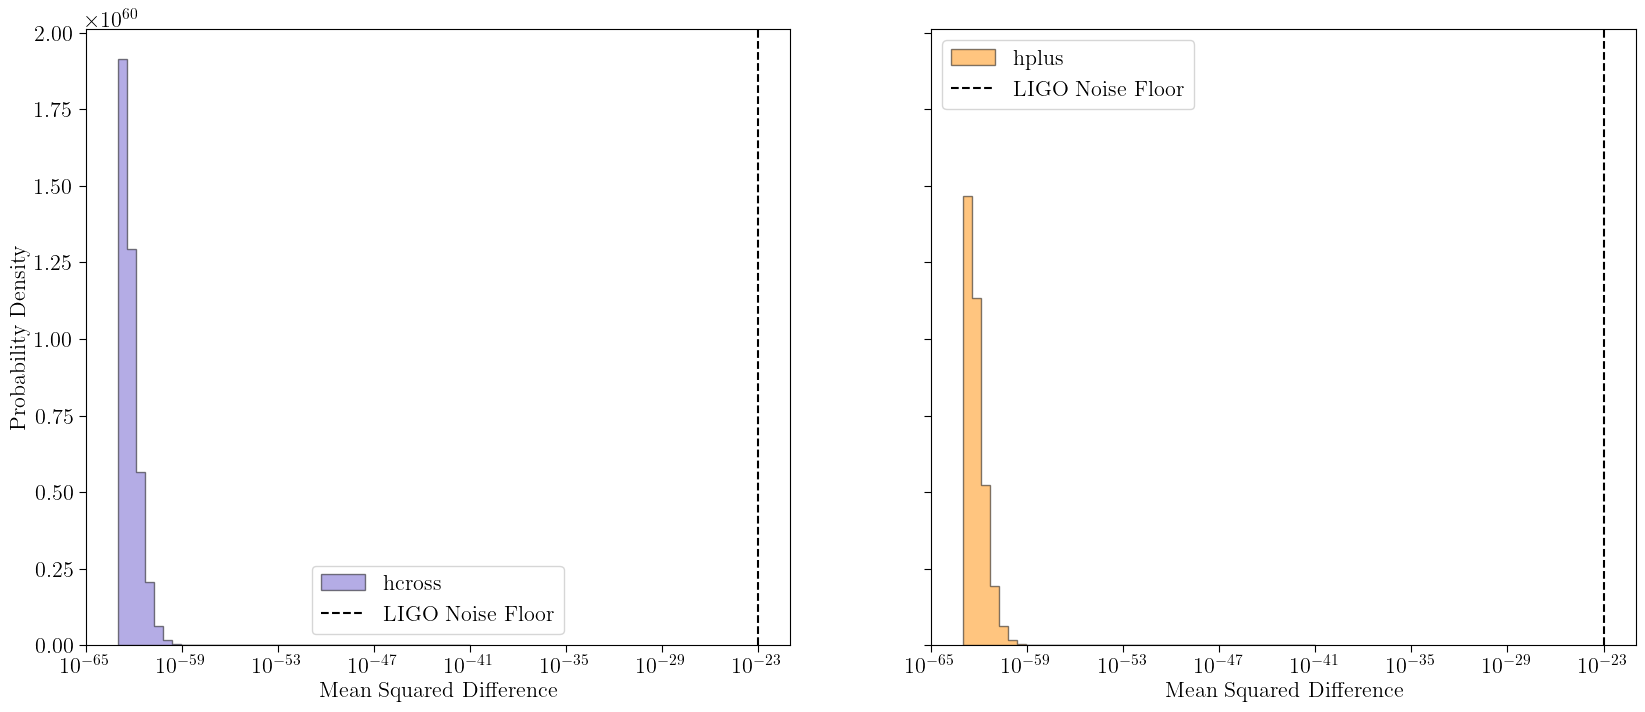

In [8]:
for diff_hcross, diff_hplus, title in zip([max_diff_hcross, mean_diff_hcross, mean_squared_diff_hcross], [max_diff_hplus, mean_diff_hplus, mean_squared_diff_hplus], ["Max", "Mean", "Mean Squared"]):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

    min_exp = int(np.log10(np.min(diff_hcross[diff_hcross>0])))
    max_exp = int(np.log10(np.max(diff_hcross)))

    ax[0].hist(diff_hcross, bins=np.logspace(min_exp, max_exp, 40), alpha=0.5, label="hcross", color="slateblue", density=True, histtype="stepfilled", edgecolor="black")
    ax[0].axvline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
    ax[0].set_xscale("log")
    ax[0].set_xlabel(f"{title} Difference")
    ax[0].set_ylabel("Probability Density")
    ax[0].legend()

    min_exp = int(np.log10(np.min(diff_hplus[diff_hplus>0])))
    max_exp = int(np.log10(np.max(diff_hplus)))

    ax[1].hist(diff_hplus, bins=np.logspace(min_exp, max_exp, 40), alpha=0.5, label="hplus", color="darkorange", density=True, histtype="stepfilled", edgecolor="black")
    ax[1].axvline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
    ax[1].set_xscale("log")
    ax[1].set_xlabel(f"{title} Difference")
    ax[1].legend()

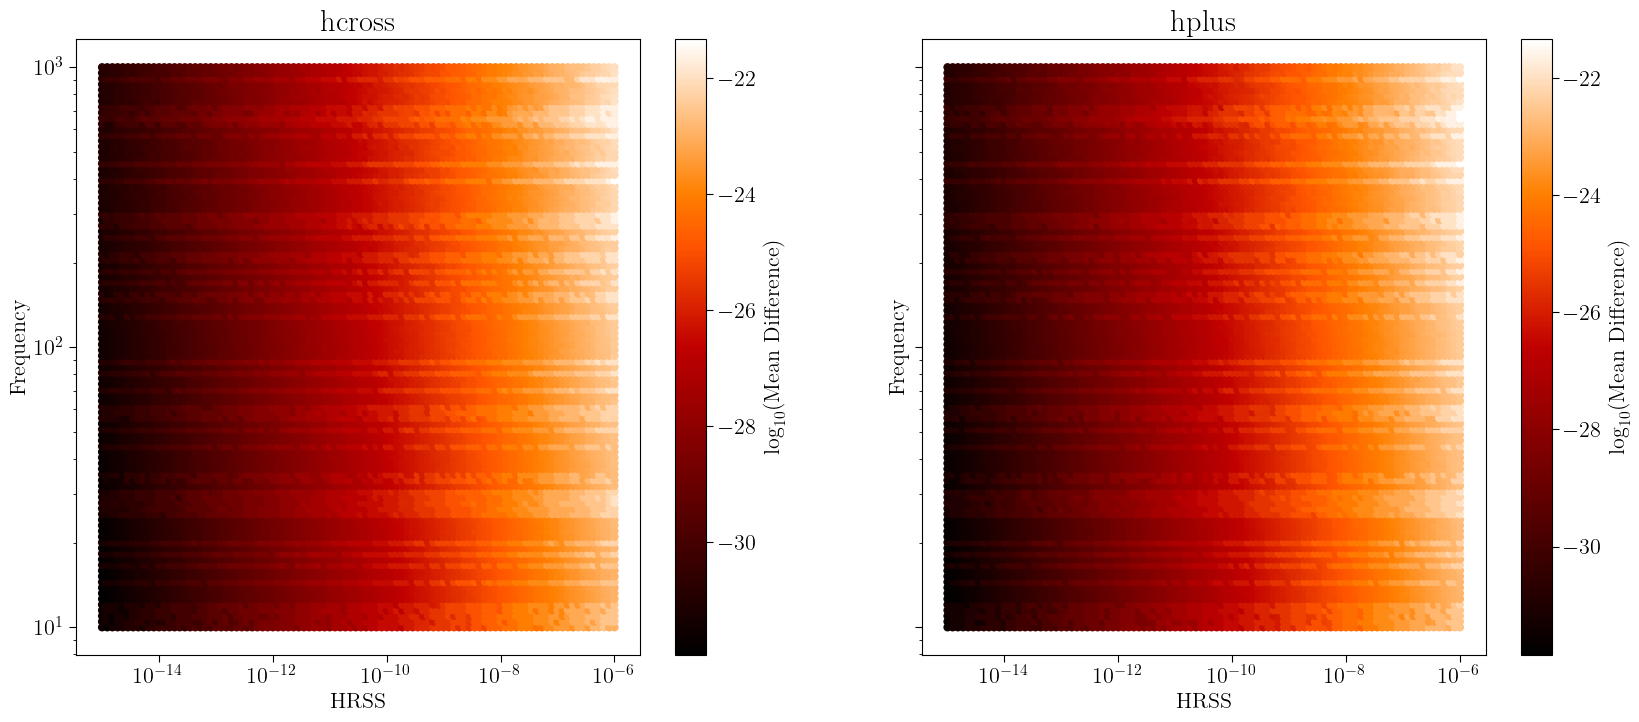

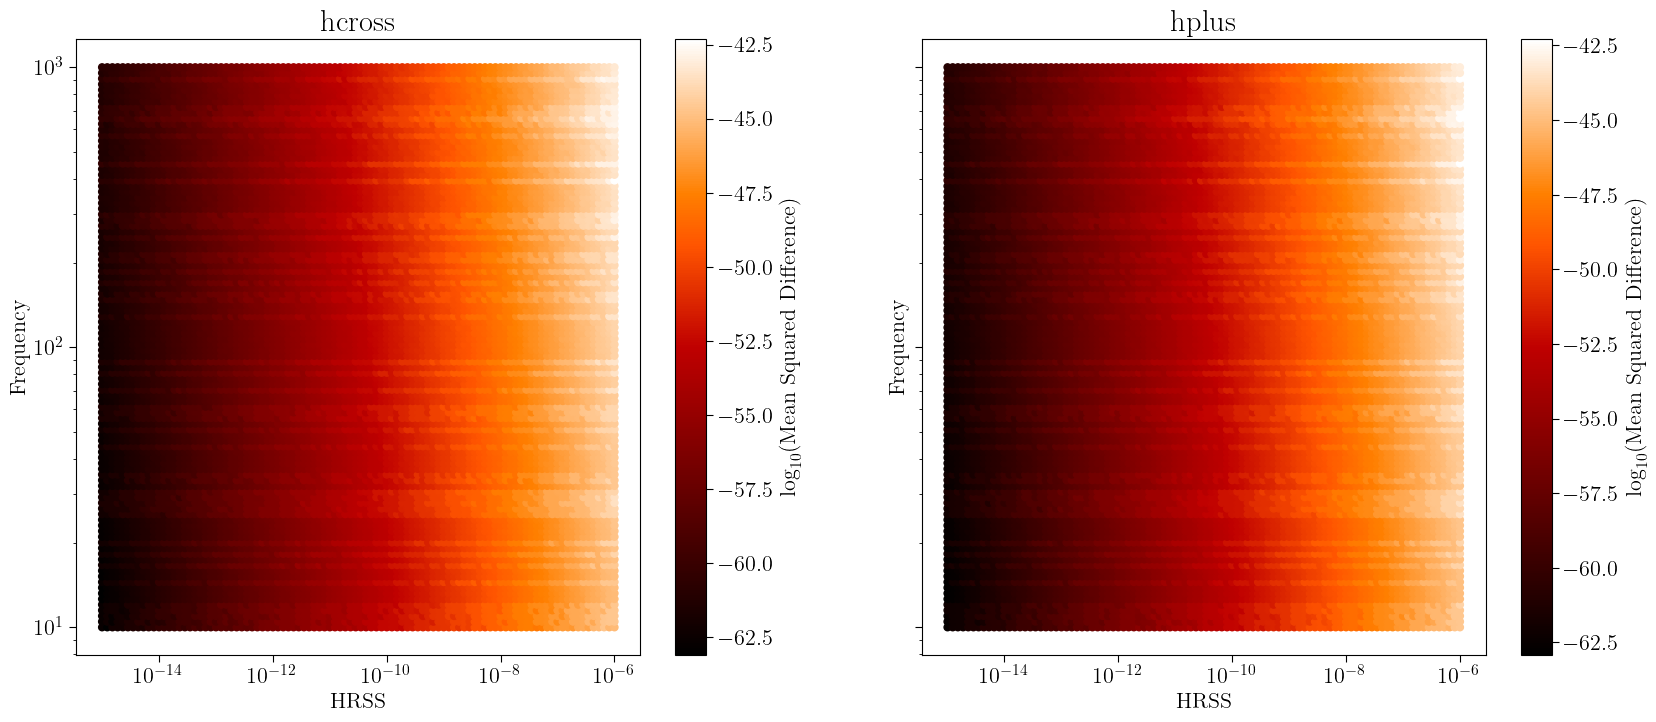

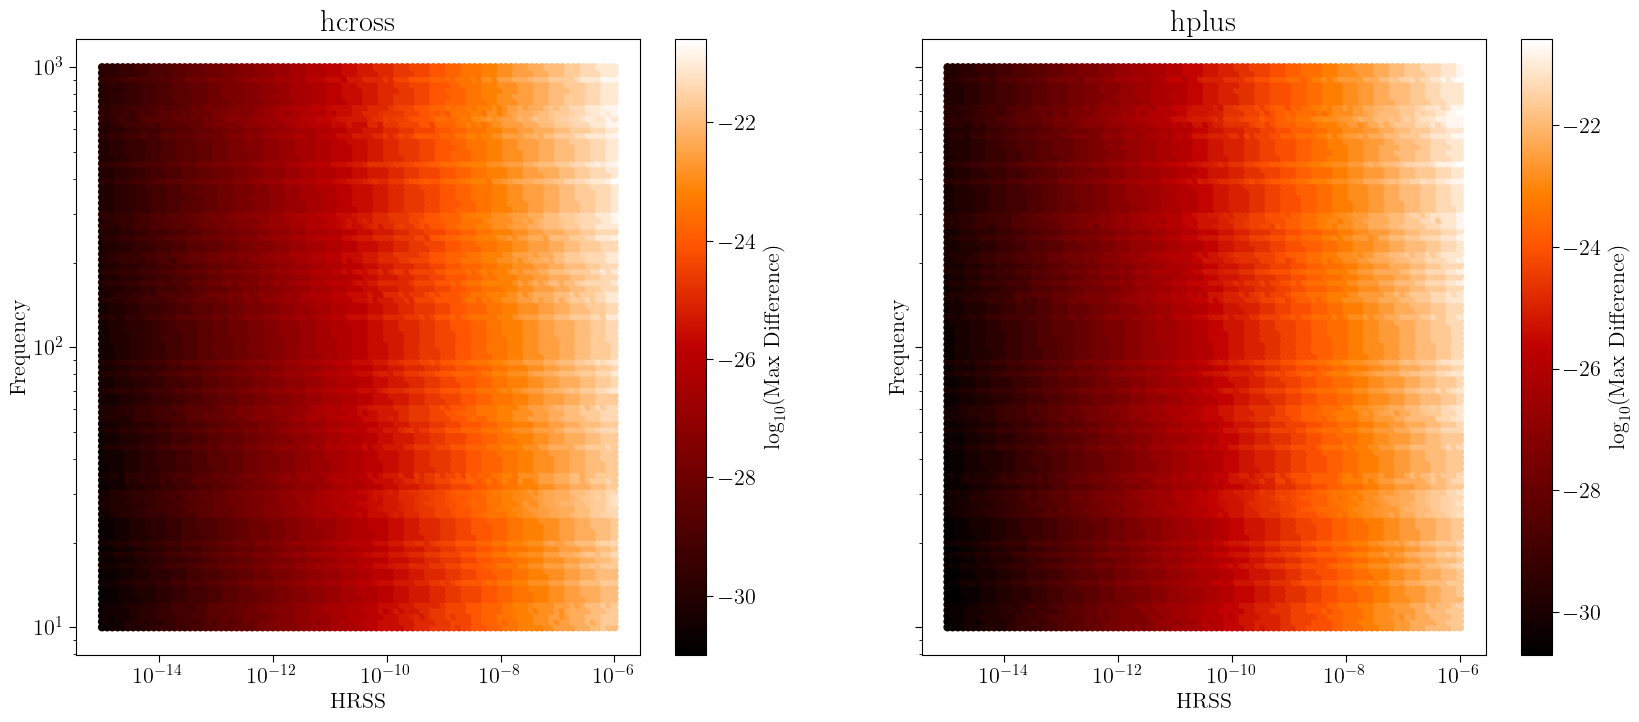

In [9]:
mask = np.where(quality == np.sort([*set(np.array(quality))])[5])
frequency_ = frequency[mask]
hrss_ = hrss[mask]

mean_diff_hcross_ = mean_diff_hcross[mask]
mean_diff_hplus_ = mean_diff_hplus[mask]
mean_squared_diff_hcross_ = mean_squared_diff_hcross[mask]
mean_squared_diff_hplus_ = mean_squared_diff_hplus[mask]
max_diff_hcross_ = max_diff_hcross[mask]
max_diff_hplus_ = max_diff_hplus[mask]

for (diff_hcross, diff_hplus, title) in zip([mean_diff_hcross_, mean_squared_diff_hcross_, max_diff_hcross_], [mean_diff_hplus_, mean_squared_diff_hplus_, max_diff_hplus_], ["Mean", "Mean Squared", "Max"]):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    for i, (diff, label) in enumerate(zip([diff_hcross, diff_hplus], ["hcross", "hplus"])):
        scatter = ax[i].scatter(hrss_, frequency_, c=np.log10(diff), cmap="gist_heat", s=25)
        ax[i].set_xscale("log")
        ax[i].set_yscale("log")
        ax[i].set_xlabel("HRSS")
        ax[i].set_ylabel("Frequency")
        ax[i].set_title(label, fontsize=22)
        fig.colorbar(scatter, ax=ax[i], label=f"$\log_{{10}}$({title} Difference)")

# **32-bit Precision**

In [10]:
#disable 64-bit precision
jax.config.update("jax_enable_x64", False)
print(jnp.ones(1).dtype)

float32


### Vary each parameter independently by fixing others

The constant values of other parameters were chosen to be somewhere in the middle of the range, except for the hrss value which was chosen just slightly lower than value that crosses the noise floor

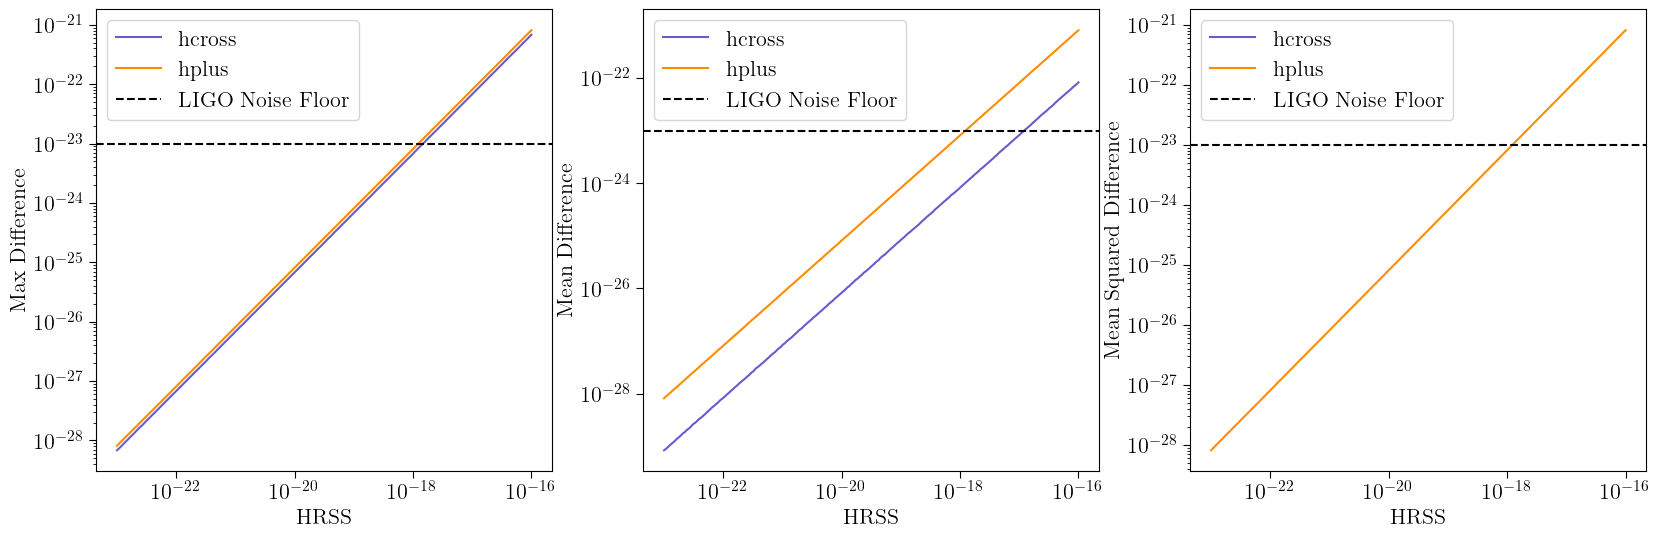

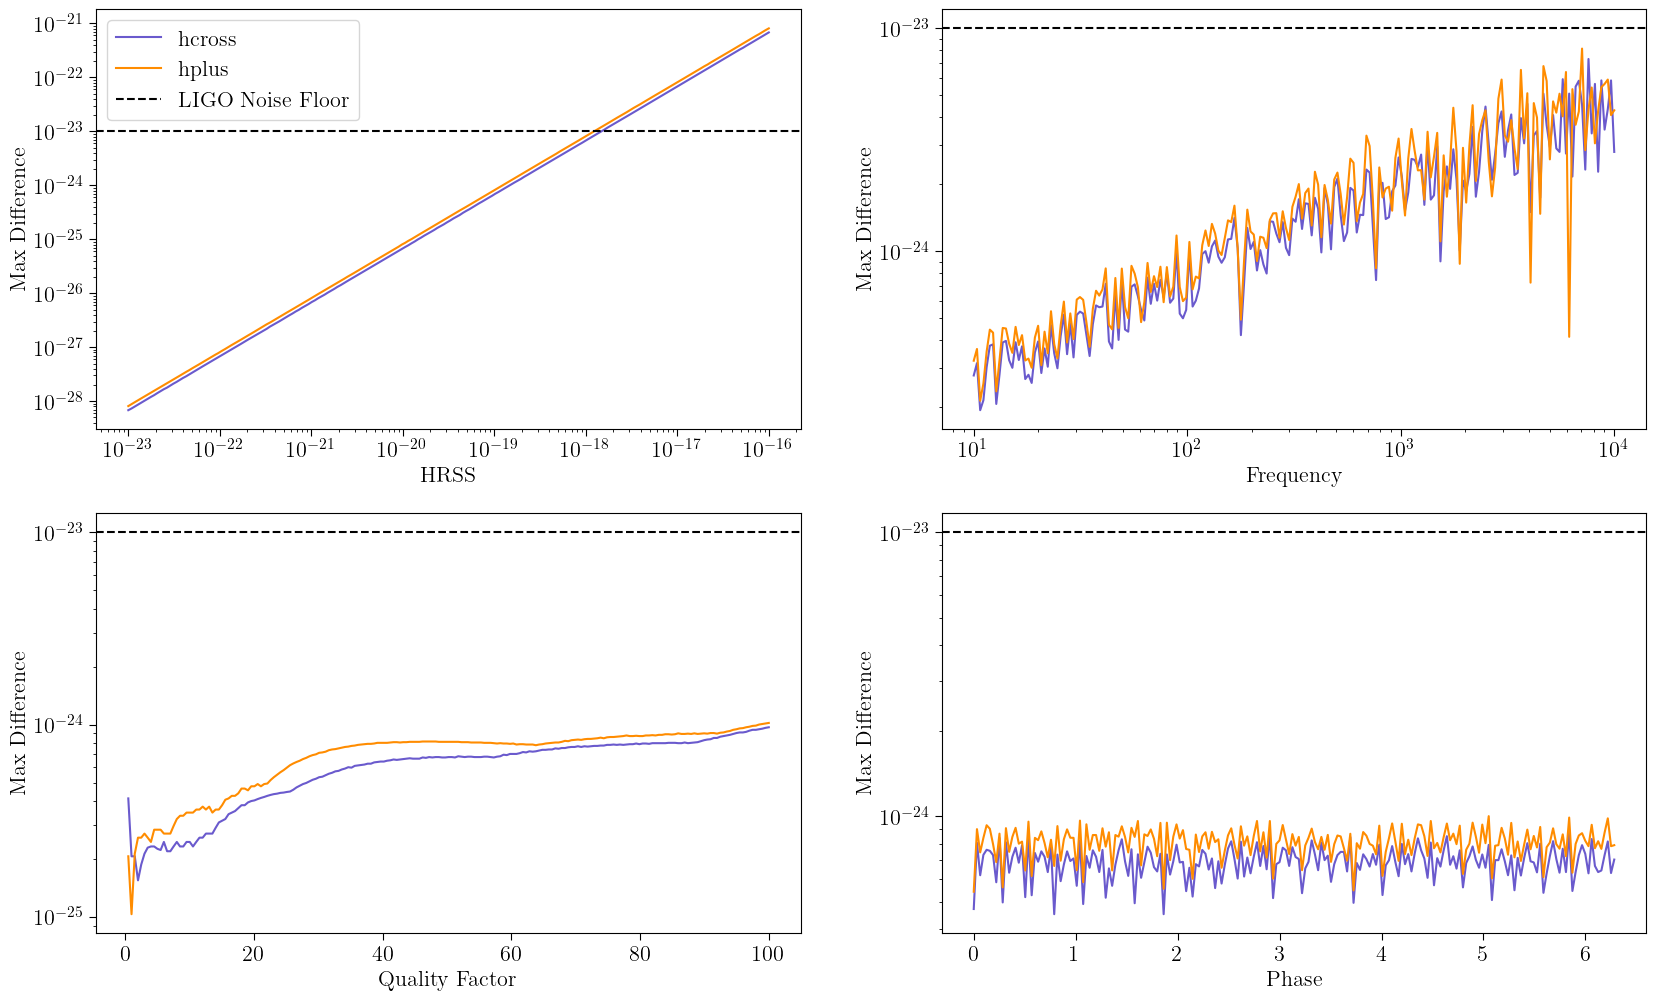

In [11]:
N = 200
LIGO_NOISE_FLOOR = 1e-23 # https://www.ligo.org/science/Publication-O1Noise/Images/IFO_STRAIN.png


quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), 100*jnp.ones(N), \
    jnp.logspace(-23, -16, N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)

max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)
mean_diff_hcross, mean_diff_hplus = get_mean_difference(diff_hcross, diff_hplus)
mean_squared_diff_hcross, mean_squared_diff_hplus = get_mean_squared_difference(diff_hcross, diff_hplus)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, (diff, label) in enumerate(zip([max_diff_hcross, mean_diff_hcross, mean_squared_diff_hcross], ["Max", "Mean", "Mean Squared"])):
    ax[i].plot(hrss, diff, label="hcross", color="slateblue")
    ax[i].plot(hrss, max_diff_hplus, label="hplus", color="darkorange")
    ax[i].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlabel("HRSS")
    ax[i].set_ylabel(f"{label} Difference")
    ax[i].legend()
plt.show()


fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax[0, 0].plot(hrss, max_diff_hcross, label="hcross", color="slateblue")
ax[0, 0].plot(hrss, max_diff_hplus, label="hplus", color="darkorange")
ax[0, 0].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[0, 0].set_xscale("log")
ax[0, 0].set_yscale("log")
ax[0, 0].set_xlabel("HRSS")
ax[0, 0].set_ylabel("Max Difference")
ax[0, 0].legend()

quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), jnp.logspace(1, 4, N), \
    1e-19*jnp.ones(N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)
max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)

ax[0, 1].plot(frequency, max_diff_hcross, label="hcross", color="slateblue")
ax[0, 1].plot(frequency, max_diff_hplus, label="hplus", color="darkorange")
ax[0, 1].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[0, 1].set_xscale("log")
ax[0, 1].set_yscale("log")
ax[0, 1].set_xlabel("Frequency")
ax[0, 1].set_ylabel("Max Difference")

quality, frequency, hrss, phase, eccentricity = jnp.linspace(0, 100, N), 100*jnp.ones(N), \
    1e-19*jnp.ones(N), jnp.pi*jnp.ones(N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)
max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)


ax[1, 0].plot(quality, max_diff_hcross, label="hcross", color="slateblue")
ax[1, 0].plot(quality, max_diff_hplus, label="hplus", color="darkorange")
ax[1, 0].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[1, 0].set_yscale("log")
ax[1, 0].set_xlabel("Quality Factor")
ax[1, 0].set_ylabel("Max Difference")


quality, frequency, hrss, phase, eccentricity = 50*jnp.ones(N), 100*jnp.ones(N), \
    1e-19*jnp.ones(N), jnp.linspace(0, 2*jnp.pi, N), 0.5*jnp.ones(N)
*_, diff_hcross, diff_hplus = vary_parameters(
    quality, frequency, hrss, phase, eccentricity
)
max_diff_hcross, max_diff_hplus = get_max_difference(diff_hcross, diff_hplus)

ax[1, 1].plot(phase, max_diff_hcross, label="hcross", color="slateblue")
ax[1, 1].plot(phase, max_diff_hplus, label="hplus", color="darkorange")
ax[1, 1].axhline(LIGO_NOISE_FLOOR, label="LIGO Noise Floor", linestyle="--", color="black")
ax[1, 1].set_yscale("log")
ax[1, 1].set_xlabel("Phase")
ax[1, 1].set_ylabel("Max Difference")

plt.show()

# **Conclusions**
64 bit precision gives waveforms usable till HRSS values of ~$10^{-9}$, whereas 32-bit precision is only usable upto HRSS of ~$10^{-19}$; a factor of $10^{10}$ lower than 64-bits.